# Kermack - McKendrick model of Epidemics

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

## SEIR modeling
Ref: https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296

In [2]:
#Extension to SEIR model
# The SEIR model differential equations.
def derivseir(y, t, N, beta, alpha, gamma, quarantine_fraction=0):
    '''
    Function to compute the rate of change for various compartments
    
    This model has a quarantine fraction - of all the infected, a certain fraction are quarantined, while 
    others escape quarantine and infect others
    
    # If I are infected, [(1-quarantine_fraction) X I] will be roaming free, and infect more people
    # If quarantine_fraction == 1, all infected are quarantined, and disease will not spread to others
    '''
    
    S, E, I, R = y
    
    # fraction of all infected, who are not quarantined, infecting others    
    newI = (1.0 -quarantine_fraction) * I
    
    # new rate of change for susceptible people - based on those that escape quarantine
    dSdt = -beta * S * newI / N
    
    #new rate of change for exposed people
    dEdt = beta * S * newI / N - alpha * E
    
    #this will not change, as those already exposed will start showing symptoms
    dIdt = alpha * E - gamma * I
    
    #this will not change, as all those infected will recover or reach an outcome
    dRdt = gamma * I
    
    return dSdt, dEdt, dIdt, dRdt

In [3]:
def predictcases(population, infected, incubation_period, infectious_period, beta, \
                 EbyIratio=2.4, days=30,  quarantine_fraction=0):
    '''
    function to predict the number of cases, based on population, initial infected and parameters
    Input parameters
    population: population of city/state/country
    infected: no of infected cases at start
    incubation_period: time to show symptoms (in days)
    infectious_period: time duration for which a patient can infect others (in days)
    beta: sent in as a value. this is being estimated by the meta function that calls this function
    EbyIratio: exposed to infected ratio
    quarantine_fraction: fraction of infected that are quarantined (0 to 1)
    '''
    ###########################################################################
    ## OLD VALUES - NOW BEING PASSED FROM OUTSIDE THIS FUNCTION
    ## Parameters from literature
    
    ### Incubation period 
    ### (https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported)
    #incubation_period = 5 # days
    
    ## Infectious period
    ## (https://www.who.int/bulletin/online_first/20-255695.pdf)
    #infectious_period  = 2.3 #days
    
    ## Exposed to infected ratio
    ## (https://www.who.int/bulletin/online_first/20-255695.pdf)
    #ebyiratio = 2.4        
    ###########################################################################
    alpha = 1/incubation_period
    #print (alpha)
    
    gamma = 1/infectious_period
    #print (gamma)

    
    # Total population, N.
    
    # Initial number of infected, exposed and recovered individuals, I0 and R0.
    I0 = infected
    E0 = EbyIratio  * I0
    R0 = 0
    N = population
    
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - E0 - I0 - R0
    
    # A grid of time points (in days)
    t = np.linspace(0, days, days+1)
    #print (t)

    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(derivseir, y0, t, args=(N, beta, alpha, gamma, quarantine_fraction))
    S, E, I, R = ret.T
    
    return (t, S, E, I, R)

In [4]:
def esterror(actual_cases, t, S, E, I, R):
    '''
    function to estimate the RMS error between true and predicted values
    actual_cases: array of daily cases
    t: time
    S: daily susceptible cases
    E: daily exposed cases
    I: daily infected cases
    R: daily recovered cases
    '''
    
    #number of observations, to compare for error
    truedays = len(actual_cases)
    predictdays = len(I)
    mindays = min(truedays, predictdays)
    #print (truedays, predictdays, mindays)
    
    # true cases
    y_true = np.array(actual_cases[:mindays]) 
    
    # predicted cases - both infected as well as recovered
    y_pred = np.array(I[:mindays] + R[:mindays])
    
    #print (len(y_true), len(y_pred))
    
    diff = (y_true - y_pred)/(y_true)
    #print (len(diff))
    
    error = np.sqrt(np.mean(diff**2))
    #print (error)
    
    return (error)

In [5]:
## function to estimate best beta and return the best value
def estbeta(df, pop, infected, days, betamin, betamax, incubation_period=5, infectious_period=2.3, \
            EbyIratio=2.4,  nint=21, quarantine_fraction=0):
    '''
    function to estimate the best beta for a case
    
    variables to predict cases function
    predictcases(population, infected, incubation_period, infectious_period, beta, EbyIratio=2.4, days=30):
    '''

    maxerror = 1e5
    finalbeta = 0
    
    betalist = list(np.linspace(betamin, betamax, nint))
    print (betalist)

    for betal in betalist:
        
        t,S,E,I, R = predictcases(population= pop, infected = infected, days=days, \
                                  incubation_period=incubation_period, \
                                  infectious_period = infectious_period, beta = betal, EbyIratio=EbyIratio, 
                                  quarantine_fraction = quarantine_fraction)
        
        actual_cases = np.array(df['Cases'])
        
        error = esterror(actual_cases, t, S, E, I, R)
        
        #print (error)
        if (error < maxerror): 
            finalbeta = betal
            maxerror = error
    print (finalbeta)
    
    return (finalbeta)

## Download data from URL and process

In [6]:
def rettable(url):
    tbls = pd.read_html(url)
    lst = []
    for t in tbls:
        return (t)
    return ()

def cleantbl(df, country):
    new = df[df['Country/Region'] == country]
    new = new.groupby('Country/Region').agg('sum')
    new = new.reset_index()
    newT = new.T
    newTH = newT[5:]
    newTH = newTH.reset_index()
    newTH.columns = ['Date', 'Cases']
    newTH['Date'] = pd.to_datetime(newTH['Date'], infer_datetime_format = True)
    newTH['Cases'] = newTH['Cases'].astype(int)
    newTH['LogCases'] = newTH['Cases'].apply(lambda x: np.log(1+x))
    return (newTH)

## Read data for Italy
url = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = rettable(url)
df.head()
df.to_csv('AllData.csv')

In [7]:
def after100cases(df):
    '''
    function to return cases after 100
    '''
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format = True)
    df1 = df[df['Cases'] >= 100]
    df1['Days'] = 0
    df1['Days'] = df1['Date'].apply(lambda x: (x - df1['Date'].iloc[0]).days)
    return (df1)

## Case for Italy

In [8]:
italypop = 60550075
italy = cleantbl(df, 'Italy')
italy.head()

,Date,Cases,LogCases
0,2020-01-23,0,0.0
1,2020-01-24,0,0.0
2,2020-01-25,0,0.0
3,2020-01-26,0,0.0
4,2020-01-27,0,0.0


In [9]:
italy100 = after100cases(italy)
italyinfected = italy100.Cases.iloc[0]
print (italyinfected)
italy100.head()

155


/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Cases,LogCases,Days
31,2020-02-23,155,5.049856,0
32,2020-02-24,229,5.438079,1
33,2020-02-25,322,5.777652,2
34,2020-02-26,453,6.118097,3
35,2020-02-27,655,6.486161,4


In [10]:
italy100[italy100['Date'] == '2020-03-09']

,Date,Cases,LogCases,Days
46,2020-03-09,9172,9.12402,15


In [11]:
## strategy: check in larger intervals first, eg. 1, 1.2, 1.4, 1.6, 1.8, 2.0, by setting bmin=1, bmax=2
## if beta = 1.2, then, check in smaller intervals, eg. 1.10, 1.12, 1,28, 1.30, by setting bmin=1, bmax=1.4
bmin = 1.2
bmax= 1.4


## get the estimate of beta
betaest = estbeta(df=italy100, pop=italypop, infected=italyinfected, days=15, betamin= bmin, betamax = bmax, nint=21)
print (betaest)
print (betaest * 2.3)

[1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.2999999999999998, 1.31, 1.3199999999999998, 1.3299999999999998, 1.3399999999999999, 1.3499999999999999, 1.3599999999999999, 1.3699999999999999, 1.38, 1.39, 1.4]
1.3299999999999998
1.3299999999999998
3.0589999999999993


In [12]:
def plotgraph(df, t, S, E, I, R, country, days):
    
    d1 = len(df['Days'])
    d2 = len(t)
    print (d1, d2)
    mindays = min(d1, d2)
    print (mindays)
    
    plt.plot(t, I+R, '-o')
    plt.plot(df['Days'], df['Cases'], '*')
    plt.yscale("log")
    #plt.ylim(0, 1e10)
    plt.xlim(0, mindays)
    plt.legend(['Predicted', 'Actual'])
    plt.grid(True)
    plt.xlabel('Days since 100th case')
    plt.ylabel('Total # of cases')
    plt.title(country)
    plt.show()
    
    return ()

69 61
61


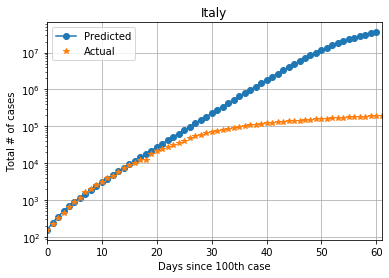

()

In [13]:
## Estimate values of the best beta
t,S,E,I, R = predictcases(population= italypop, infected = italyinfected, incubation_period=5, \
                          infectious_period = 2.3, beta = betaest, EbyIratio=2.4, days=60)

plotgraph(italy100, t, S, E, I, R, country='Italy', days=15)

In [72]:
def plotgraph2(df, t, S, E, I, R, country, uptodate, mindate='2020-02-23', maxdate = '2020-05-01'):
    
    dfv = pd.DataFrame([t, S, E, I, R])
    dfv = dfv.T
    dfv.columns = ['Days', 'S', 'E', 'I', 'R']
    dftot = pd.merge(df, dfv, how='left', on='Days')
    
    dftot = dftot[dftot['Date'] <= uptodate]    
    
    fig = plt.figure(figsize=(10,6))
    plt.plot(dftot['Date'], dftot['I'] + dftot['R'], '-o')
    plt.plot(dftot['Date'], dftot['Cases'], '*')
    plt.yscale("log")
    #plt.vlines('2020-03-09', 0, 1e7, linestyles='dashed')
    #plt.text('2020-03-10', 1e3, 'Italy LockDown', fontsize=18, )
    plt.ylim(1e2, 1e5)
    plt.xlim(mindate, maxdate)
    plt.legend(['Predicted', 'Actual'], loc=4)
    plt.grid(True)
    
    plt.xlabel('Date')
    plt.xticks(rotation=90)
    plt.ylabel('Total # of cases')
    plt.title(country)
    plt.show()
    return ()


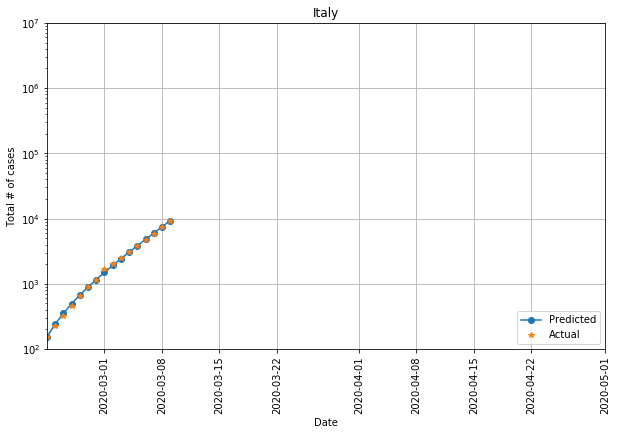

()

In [37]:
plotgraph2(italy100, t, S, E, I, R, country='Italy', mindate='2020-02-23', maxdate = '2020-05-01', uptodate='2020-03-09')

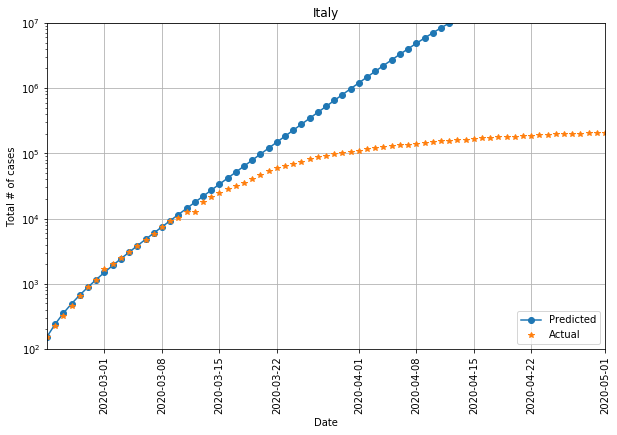

()

In [38]:
plotgraph2(italy100, t, S, E, I, R, country='Italy', uptodate='2020-05-01' )

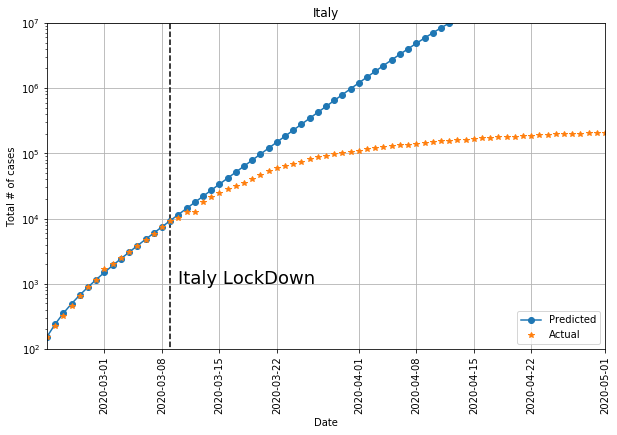

()

In [54]:
plotgraph2(italy100, t, S, E, I, R, country='Italy', uptodate='2020-05-01' )

In [55]:
## Cases for Brazil

In [56]:
brazilpop = 212559417  #https://www.worldometers.info/world-population/brazil-population/
brazil = cleantbl(df, 'Brazil')
brazil.tail()
brazil100 = after100cases(brazil)
brazilinfected = brazil100.Cases.iloc[0]
print (brazilinfected)
brazil100.head()

151


/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Cases,LogCases,Days
50,2020-03-13,151,5.023881,0
51,2020-03-14,151,5.023881,1
52,2020-03-15,162,5.093750,2
53,2020-03-16,200,5.303305,3
54,2020-03-17,321,5.774552,4


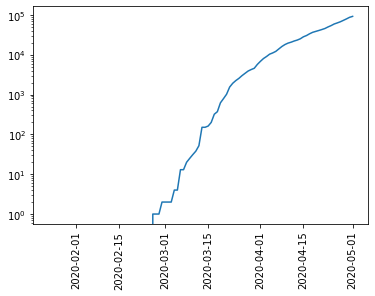

In [57]:
plt.plot(brazil['Date'], brazil['Cases'])
plt.yscale("log")
plt.xticks(rotation=90)
plt.show()

In [70]:
## strategy: check in larger intervals first, eg. 1, 1.2, 1.4, 1.6, 1.8, 2.0, by setting bmin=1, bmax=2
## if beta = 1.2, then, check in smaller intervals, eg. 1.10, 1.12, 1,28, 1.30, by setting bmin=1, bmax=1.4
bmin = 0.6
bmax= 0.8


## get the estimate of beta
betaest = estbeta(df=brazil100, pop=brazilpop, infected=brazilinfected, days=15, betamin= bmin, betamax = bmax, nint=21)
print (betaest)
print (betaest * 2.3)

[0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8]
0.78
0.78
1.7939999999999998


50 61
50


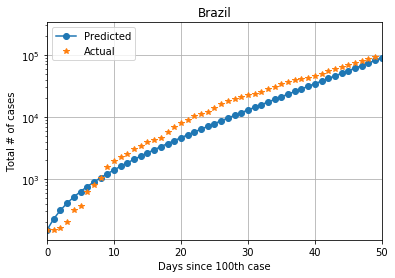

()

In [71]:
t,S,E,I, R = predictcases(population= brazilpop, infected = brazilinfected, incubation_period=5, \
                          infectious_period = 2.3, beta = betaest, EbyIratio=2.4, days=60)

plotgraph(brazil100, t, S, E, I, R, country='Brazil', days=35)

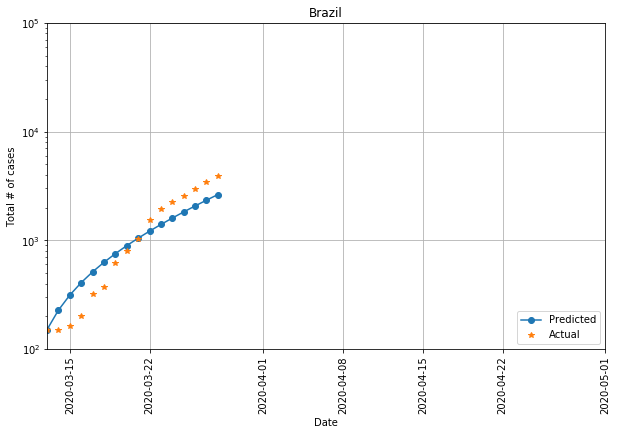

()

In [73]:
plotgraph2(brazil100, t, S, E, I, R, country='Brazil', mindate='2020-03-13', maxdate = '2020-05-01', uptodate='2020-03-28')

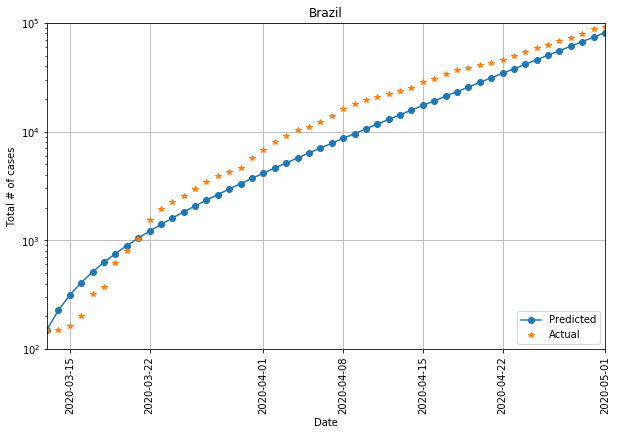

()

In [74]:
plotgraph2(brazil100, t, S, E, I, R, country='Brazil', mindate='2020-03-13', maxdate = '2020-05-01', uptodate='2020-05-01')